In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.widgets as widgets
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
import time
inicio = time.time()

In [24]:
class AntColonyOptimization:
    def __init__(self, num_ants, num_iterations, num_cities, alpha=1.0, beta=1.0, rho=0.5, q=100):
        self.num_ants = num_ants
        self.num_iterations = num_iterations
        self.num_cities = num_cities
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.q = q
        self.distances = np.zeros((num_cities, num_cities))
        self.pheromone = np.ones((num_cities, num_cities))
        self.ants = np.full((num_ants, num_cities), -1)
        self.best_path = None
        self.best_distance = np.inf

    def calculate_distance(self, city_a, city_b):
        print("Distancias: " + str(self.distances[city_a, city_b]))
        return self.distances[city_a, city_b]

    def update_pheromone(self):
        self.pheromone *= self.rho  # Evaporação do feromônio
        for ant in range(self.num_ants):
            path = self.ants[ant]
            distance = 0
            for i in range(self.num_cities - 1):
                city_a = path[i]
                city_b = path[i + 1]
                distance += self.calculate_distance(city_a, city_b)
            if distance < self.best_distance:
                self.best_distance = distance
                self.best_path = path
            for i in range(self.num_cities - 1): # atualizam os valores de feromônio nas trilhas percorridas pela formiga
                city_a = path[i]
                city_b = path[i + 1]
                self.pheromone[city_a, city_b] += self.q / distance

    def choose_next_city(self, ant, current_city):
        unvisited_cities = np.delete(np.arange(self.num_cities), self.ants[ant])
        if len(unvisited_cities) == 0:
            return
        pheromone = self.pheromone[current_city, unvisited_cities]
        heuristic = 1.0 / self.distances[current_city, unvisited_cities]
        probabilities = np.power(pheromone, self.alpha) * np.power(heuristic, self.beta)
        probabilities /= np.sum(probabilities)
        next_city = np.random.choice(unvisited_cities, p=probabilities)
        self.ants[ant, self.num_cities - np.sum(self.ants[ant] != -1)] = next_city

    def ACO_run(self):
        for iteration in range(self.num_iterations):
            self.ants[:, :] = -1  # Reinicializar caminhos das formigas
            for ant in range(self.num_ants):
                start_city = np.random.randint(0, self.num_cities)  # Escolher cidade de partida aleatoriamente
                self.ants[ant, 0] = start_city
                for _ in range(self.num_cities - 1):
                    current_city = self.ants[ant, np.sum(self.ants[ant] != -1) - 1]
                    self.choose_next_city(ant, current_city)
            self.update_pheromone()

    def plot_results(self):
        best_path = np.append(self.best_path, self.best_path[0])  # Adicionar cidade de partida ao final do caminho
        x = np.linspace(0, self.num_cities, self.num_cities + 1)
        y = np.zeros(self.num_cities + 1)
        for i in range(self.num_cities):
            y[i] = self.distances[best_path[i], best_path[i + 1]]
        y[-1] = self.distances[best_path[-1], best_path[0]]  # Distância da última cidade até a cidade de partida
        plt.plot(x, y, 'bo-')
        plt.xlabel('City')
        plt.ylabel('Distance')
        plt.title('Best Path')
        plt.show()

    def print_results(self):
        print("Best Path:", self.best_path)
        print("Best Distance:", self.best_distance)

    def calculate_MQ(self):
        # Criar uma matriz de adjacência para representar as conexões entre as cidades
        adjacency_matrix = np.zeros((self.num_cities, self.num_cities), dtype=int)
        for ant in range(self.num_ants):
            path = self.ants[ant]
            for i in range(self.num_cities - 1):
                city_a = path[i]
                city_b = path[i + 1]
                adjacency_matrix[city_a, city_b] = 1
                adjacency_matrix[city_b, city_a] = 1
        
        # Calcular a MQ
        within_module_distances = np.sum(adjacency_matrix * self.distances)
        total_distances = np.sum(self.distances)
        MQ = within_module_distances / total_distances
        return MQ

    def show_ant_paths(self):
        for ant in range(self.num_ants):
            path = self.ants[ant]
            path = np.append(path, path[0])  # Adicionar cidade de partida ao final do caminho
            x = [i for i in range(self.num_cities + 1)]
            y = [self.distances[path[i], path[i+1]] for i in range(self.num_cities)]
            y.append(self.distances[path[-1], path[0]])  # Adicionar a distância da última cidade até a cidade de partida
            plt.plot(x, y, marker='o', linestyle='-', label=f'Ant {ant+1}')

        plt.xlabel('City')
        plt.ylabel('Distance')
        plt.title('Ant Paths')
        plt.show()

    def show_ant_paths_with_best(self):
        best_path = np.append(self.best_path, self.best_path[0])  # Adicionar cidade de partida ao final do caminho
        x = [i for i in range(self.num_cities + 1)]
        y_best = [self.distances[best_path[i], best_path[i+1]] for i in range(self.num_cities)]
        y_best.append(self.distances[best_path[-1], best_path[0]])  # Adicionar a distância da última cidade até a cidade de partida
        plt.plot(x, y_best, marker='o', linestyle='-', color='red', label='Best Path')

        for ant in range(self.num_ants):
            path = self.ants[ant]
            path = np.append(path, path[0])  # Adicionar cidade de partida ao final do caminho
            x = [i for i in range(self.num_cities + 1)]
            y = [self.distances[path[i], path[i+1]] for i in range(self.num_cities)]
            y.append(self.distances[path[-1], path[0]])  # Adicionar a distância da última cidade até a cidade de partida
            plt.plot(x, y, marker='o', linestyle='-', alpha=0.1)

        plt.xlabel('City')
        plt.ylabel('Distance')
        plt.title('Ant Paths with Best')
        plt.legend()
        plt.show()
        
    def show_city_matrix(self):
        city_df = pd.DataFrame(self.distances)
        print("City Matrix:")
        print(city_df)

    def show_ant_matrix(self):
        ant_df = pd.DataFrame(self.ants)
        print("Ant Matrix:")
        print(ant_df)


Distancias: 3
Distancias: 27
Distancias: 23
Distancias: 101
Distancias: 72
Distancias: 29
Distancias: 4
Distancias: 16
Distancias: 12
Distancias: 25
Distancias: 90
Distancias: 100
Distancias: 21
Distancias: 29
Distancias: 40
Distancias: 36
Distancias: 23
Distancias: 14
Distancias: 31
Distancias: 25
Distancias: 15
Distancias: 25
Distancias: 15
Distancias: 25
Distancias: 95
Distancias: 94
Distancias: 28
Distancias: 27
Distancias: 16
Distancias: 16
Distancias: 29
Distancias: 21
Distancias: 90
Distancias: 101
Distancias: 36
Distancias: 12
Distancias: 35
Distancias: 99
Distancias: 94
Distancias: 16
Distancias: 12
Distancias: 12
Distancias: 21
Distancias: 29
Distancias: 20
Distancias: 41
Distancias: 25
Distancias: 15
Distancias: 23
Distancias: 15
Distancias: 12
Distancias: 16
Distancias: 94
Distancias: 100
Distancias: 27
Distancias: 31
Distancias: 16
Distancias: 16
Distancias: 12
Distancias: 92
Distancias: 101
Distancias: 29
Distancias: 21
Distancias: 13
Distancias: 27
Distancias: 15
Distanc

Distancias: 27
Distancias: 15
Distancias: 21
Distancias: 15
Distancias: 36
Distancias: 12
Distancias: 21
Distancias: 16
Distancias: 94
Distancias: 99
Distancias: 13
Distancias: 12
Distancias: 21
Distancias: 15
Distancias: 25
Distancias: 36
Distancias: 20
Distancias: 16
Distancias: 27
Distancias: 31
Distancias: 4
Distancias: 36
Distancias: 95
Distancias: 72
Distancias: 21
Distancias: 12
Distancias: 4
Distancias: 27
Distancias: 13
Distancias: 12
Distancias: 16
Distancias: 16
Distancias: 12
Distancias: 90
Distancias: 72
Distancias: 29
Distancias: 41
Distancias: 27
Distancias: 25
Distancias: 95
Distancias: 100
Distancias: 4
Distancias: 15
Distancias: 9
Distancias: 4
Distancias: 99
Distancias: 31
Distancias: 16
Distancias: 9
Distancias: 12
Distancias: 25
Distancias: 29
Distancias: 15
Distancias: 25
Distancias: 35
Distancias: 13
Distancias: 92
Distancias: 90
Distancias: 9
Distancias: 14
Distancias: 28
Distancias: 40
Distancias: 31
Distancias: 41
Distancias: 25
Distancias: 24
Distancias: 25
D

Distancias: 29
Distancias: 101
Distancias: 35
Distancias: 99
Distancias: 90
Distancias: 9
Distancias: 14
Distancias: 16
Distancias: 12
Distancias: 29
Distancias: 29
Distancias: 31
Distancias: 20
Distancias: 23
Distancias: 20
Distancias: 28
Distancias: 29
Distancias: 12
Distancias: 24
Distancias: 90
Distancias: 25
Distancias: 41
Distancias: 29
Distancias: 4
Distancias: 16
Distancias: 100
Distancias: 81
Distancias: 25
Distancias: 36
Distancias: 25
Distancias: 41
Distancias: 29
Distancias: 21
Distancias: 100
Distancias: 95
Distancias: 16
Distancias: 20
Distancias: 23
Distancias: 16
Distancias: 25
Distancias: 15
Distancias: 4
Distancias: 31
Distancias: 95
Distancias: 72
Distancias: 29
Distancias: 15
Distancias: 16
Distancias: 13
Distancias: 12
Distancias: 36
Distancias: 15
Distancias: 9
Distancias: 15
Distancias: 29
Distancias: 100
Distancias: 13
Distancias: 99
Distancias: 94
Distancias: 16
Distancias: 29
Distancias: 21
Distancias: 15
Distancias: 23
Distancias: 25
Distancias: 99
Distancias

Distancias: 35
Distancias: 41
Distancias: 15
Distancias: 81
Distancias: 90
Distancias: 24
Distancias: 16
Distancias: 4
Distancias: 21
Distancias: 41
Distancias: 21
Distancias: 24
Distancias: 36
Distancias: 25
Distancias: 15
Distancias: 14
Distancias: 94
Distancias: 100
Distancias: 31
Distancias: 31
Distancias: 24
Distancias: 90
Distancias: 92
Distancias: 25
Distancias: 29
Distancias: 28
Distancias: 14
Distancias: 99
Distancias: 100
Distancias: 20
Distancias: 23
Distancias: 20
Distancias: 9
Distancias: 12
Distancias: 12
Distancias: 40
Distancias: 31
Distancias: 41
Distancias: 29
Distancias: 15
Distancias: 9
Distancias: 14
Distancias: 81
Distancias: 95
Distancias: 12
Distancias: 31
Distancias: 16
Distancias: 9
Distancias: 12
Distancias: 12
Distancias: 36
Distancias: 29
Distancias: 15
Distancias: 81
Distancias: 16
Distancias: 41
Distancias: 29
Distancias: 100
Distancias: 90
Distancias: 9
Distancias: 15
Distancias: 12
Distancias: 36
Distancias: 35
Distancias: 31
Distancias: 16
Distancias: 

Distancias: 94
Distancias: 72
Distancias: 40
Distancias: 25
Distancias: 15
Distancias: 12
Distancias: 13
Distancias: 16
Distancias: 28
Distancias: 72
Distancias: 101
Distancias: 4
Distancias: 20
Distancias: 25
Distancias: 24
Distancias: 25
Distancias: 99
Distancias: 92
Distancias: 25
Distancias: 4
Distancias: 16
Distancias: 28
Distancias: 15
Distancias: 25
Distancias: 31
Distancias: 35
Distancias: 23
Distancias: 9
Distancias: 12
Distancias: 92
Distancias: 95
Distancias: 40
Distancias: 28
Distancias: 27
Distancias: 3
Distancias: 31
Distancias: 4
Distancias: 20
Distancias: 28
Distancias: 21
Distancias: 12
Distancias: 92
Distancias: 16
Distancias: 27
Distancias: 25
Distancias: 36
Distancias: 25
Distancias: 29
Distancias: 29
Distancias: 100
Distancias: 90
Distancias: 3
Distancias: 35
Distancias: 15
Distancias: 9
Distancias: 28
Distancias: 15
Distancias: 15
Distancias: 21
Distancias: 100
Distancias: 13
Distancias: 99
Distancias: 101
Distancias: 36
Distancias: 31
Distancias: 29
Distancias: 2

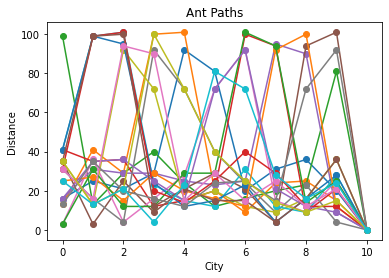

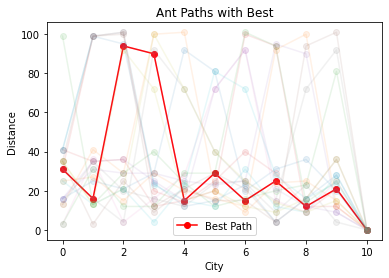

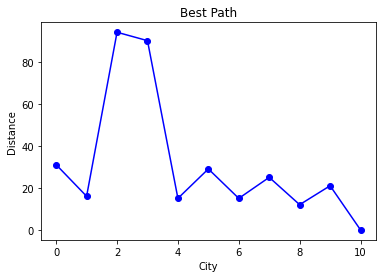


Tempo de execução:  100.82183718681335


Number of ants: 20
Number of iterations: 20
Number of cities: 10
Pheromone importance coefficiento (Alpha): 0.4
Heuristic importance coefficient (Beta): 0.1
Pheromone evaporation rate (Rho): 0.6
Modularization Quality (MQ): 1.0


In [25]:
# Definindo a matriz de distâncias
num_cities = 10

# Definir uma matriz de distâncias estática
distances = np.array([
    [0, 29, 20, 21, 16, 31, 100, 12, 4, 31],
    [29, 0, 15, 29, 28, 40, 72, 21, 29, 41],
    [20, 15, 0, 15, 14, 25, 81, 9, 23, 27],
    [21, 29, 15, 0, 4, 12, 92, 12, 25, 13],
    [16, 28, 14, 4, 0, 16, 94, 9, 20, 16],
    [31, 40, 25, 12, 16, 0, 95, 24, 36, 3],
    [100, 72, 81, 92, 94, 95, 0, 90, 101, 99],
    [12, 21, 9, 12, 9, 24, 90, 0, 15, 25],
    [4, 29, 23, 25, 20, 36, 101, 15, 0, 35],
    [31, 41, 27, 13, 16, 3, 99, 25, 35, 0]
])

# Configuração do algoritmo ACO
num_iterations = 20
num_ants = 20
rho = 0.6
alpha = 0.4
beta = 0.1
q = 100

# Criando uma instância de AntColonyOptimization
aco = AntColonyOptimization(num_ants, num_iterations, num_cities, alpha, beta, rho, q)

# Definindo a matriz de distâncias
aco.distances = distances

# Executando o algoritmo ACO
aco.ACO_run()

aco.print_results()
aco.show_ant_paths()
aco.show_ant_paths_with_best()
aco.plot_results()

mq = aco.calculate_MQ()

fim = time.time()
print("")
print("Tempo de execução: ", fim - inicio)
print("")

# Dados importantes
print('')
print("Number of ants:", num_ants)
print("Number of iterations:", num_iterations)
print("Number of cities:", num_cities)
print("Pheromone importance coefficiento (Alpha):", alpha)
print("Heuristic importance coefficient (Beta):", beta)
print("Pheromone evaporation rate (Rho):", rho)
print("Modularization Quality (MQ):", mq)